# Data Validation Notebook
## Steel Industry Load Type Prediction

This notebook handles the data validation phase of our ML pipeline.

**Objectives:**
- Load the ingested data
- Validate data quality and integrity
- Identify and handle outliers
- Perform advanced data quality checks
- Save the validated data for transformation phase

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Data Validation Phase Started")
print(f"Timestamp: {datetime.now()}")

Data Validation Phase Started
Timestamp: 2025-10-13 09:57:32.670577


## 1. Load Ingested Data

In [2]:
# Load the ingested data
input_filename = 'ingested_data.csv'

try:
    df = pd.read_csv(input_filename)
    print(f"✓ Data loaded successfully from {input_filename}")
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except FileNotFoundError:
    print(f"❌ Error: {input_filename} not found. Please run 01_data_ingestion.ipynb first.")
    raise
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

✓ Data loaded successfully from ingested_data.csv
Dataset shape: (35040, 16)
Memory usage: 11.22 MB


In [3]:
# Quick overview of loaded data
print("=== LOADED DATA OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

=== LOADED DATA OVERVIEW ===
Shape: (35040, 16)

Columns: ['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'year', 'month', 'day', 'hour', 'minute']

Data types:
date                                     object
Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
year                                      int64
month                                     int64
day                                

## 2. Data Type Validation

In [4]:
# Define expected data types for validation
expected_types = {
    'Usage_kWh': 'float64',
    'Lagging_Current_Reactive.Power_kVarh': 'float64',
    'Leading_Current_Reactive_Power_kVarh': 'float64',
    'CO2(tCO2)': 'float64',
    'Lagging_Current_Power_Factor': 'float64',
    'Leading_Current_Power_Factor': 'float64',
    'NSM': 'int64',
    'WeekStatus': 'object',
    'Day_of_week': 'object',
    'Load_Type': 'object'
}

print("=== DATA TYPE VALIDATION ===")
type_issues = []

for col, expected_type in expected_types.items():
    if col in df.columns:
        actual_type = str(df[col].dtype)
        if actual_type == expected_type:
            print(f"✓ {col}: {actual_type} (correct)")
        else:
            print(f"⚠️ {col}: {actual_type} (expected {expected_type})")
            type_issues.append((col, actual_type, expected_type))
    else:
        print(f"❌ {col}: Column not found")

if type_issues:
    print(f"\n⚠️ Found {len(type_issues)} data type issues")
else:
    print("\n✓ All data types are correct")

=== DATA TYPE VALIDATION ===
✓ Usage_kWh: float64 (correct)
✓ Lagging_Current_Reactive.Power_kVarh: float64 (correct)
✓ Leading_Current_Reactive_Power_kVarh: float64 (correct)
✓ CO2(tCO2): float64 (correct)
✓ Lagging_Current_Power_Factor: float64 (correct)
✓ Leading_Current_Power_Factor: float64 (correct)
✓ NSM: int64 (correct)
✓ WeekStatus: object (correct)
✓ Day_of_week: object (correct)
✓ Load_Type: object (correct)

✓ All data types are correct


## 3. Missing Values Analysis

In [5]:
# Comprehensive missing values analysis
print("=== MISSING VALUES ANALYSIS ===")

missing_summary = df.isnull().sum()
missing_percentage = (missing_summary / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_summary.values,
    'Missing_Percentage': missing_percentage.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print("⚠️ Columns with missing values:")
    print(missing_df)
    
    # Visualize missing values
    if len(missing_df) > 0:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        missing_df.plot(x='Column', y='Missing_Count', kind='bar', ax=plt.gca())
        plt.title('Missing Values Count by Column')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        missing_df.plot(x='Column', y='Missing_Percentage', kind='bar', ax=plt.gca())
        plt.title('Missing Values Percentage by Column')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
else:
    print("✓ No missing values found in the dataset!")

=== MISSING VALUES ANALYSIS ===
✓ No missing values found in the dataset!


## 4. Duplicate Records Validation

In [6]:
# Check for various types of duplicates
print("=== DUPLICATE RECORDS VALIDATION ===")

# Complete duplicate rows
complete_duplicates = df.duplicated().sum()
print(f"Complete duplicate rows: {complete_duplicates}")

# Duplicate rows excluding timestamp (if date column exists)
if 'date' in df.columns:
    feature_cols = [col for col in df.columns if col != 'date']
    feature_duplicates = df.duplicated(subset=feature_cols).sum()
    print(f"Duplicate rows (excluding date): {feature_duplicates}")

# Check for duplicates in key identifier combinations
if 'date' in df.columns:
    date_duplicates = df.duplicated(subset=['date']).sum()
    print(f"Duplicate timestamps: {date_duplicates}")

if complete_duplicates > 0:
    print(f"\n⚠️ Sample of duplicate rows:")
    duplicate_rows = df[df.duplicated(keep=False)].sort_values(list(df.columns))
    print(duplicate_rows.head(10))
    
    # Option to remove duplicates (commented out for safety)
    # df_clean = df.drop_duplicates()
    # print(f"Rows after removing duplicates: {len(df_clean)}")
else:
    print("✓ No duplicate records found")

=== DUPLICATE RECORDS VALIDATION ===
Complete duplicate rows: 0
Duplicate rows (excluding date): 0
Duplicate timestamps: 0
✓ No duplicate records found


## 5. Outlier Detection and Analysis

In [7]:
# Outlier detection for numerical columns
print("=== OUTLIER DETECTION AND ANALYSIS ===")

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove time-based features for outlier analysis
numerical_cols = [col for col in numerical_cols if col not in ['year', 'month', 'day', 'hour', 'minute']]

print(f"Analyzing outliers in {len(numerical_cols)} numerical columns...")

outlier_summary = []

for col in numerical_cols:
    if col in df.columns:
        # IQR method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count_iqr = len(outliers_iqr)
        outlier_percentage_iqr = (outlier_count_iqr / len(df)) * 100
        
        # Z-score method (|z| > 3)
        z_scores = np.abs(stats.zscore(df[col]))
        outliers_z = df[z_scores > 3]
        outlier_count_z = len(outliers_z)
        outlier_percentage_z = (outlier_count_z / len(df)) * 100
        
        outlier_summary.append({
            'Column': col,
            'IQR_Outliers': outlier_count_iqr,
            'IQR_Percentage': round(outlier_percentage_iqr, 2),
            'Z_Score_Outliers': outlier_count_z,
            'Z_Score_Percentage': round(outlier_percentage_z, 2),
            'Min_Value': df[col].min(),
            'Max_Value': df[col].max(),
            'Mean': round(df[col].mean(), 2),
            'Std': round(df[col].std(), 2)
        })

outlier_df = pd.DataFrame(outlier_summary)
print("\nOutlier Summary:")
print(outlier_df)

=== OUTLIER DETECTION AND ANALYSIS ===
Analyzing outliers in 7 numerical columns...

Outlier Summary:
                                 Column  IQR_Outliers  IQR_Percentage  \
0                             Usage_kWh           328            0.94   
1  Lagging_Current_Reactive.Power_kVarh          1059            3.02   
2  Leading_Current_Reactive_Power_kVarh          7759           22.14   
3                             CO2(tCO2)           437            1.25   
4          Lagging_Current_Power_Factor             1            0.00   
5          Leading_Current_Power_Factor          8327           23.76   
6                                   NSM             0            0.00   

   Z_Score_Outliers  Z_Score_Percentage  Min_Value  Max_Value      Mean  \
0               212                0.61        0.0     157.18     27.39   
1               387                1.10        0.0      96.91     13.04   
2               467                1.33        0.0      27.76      3.87   
3            

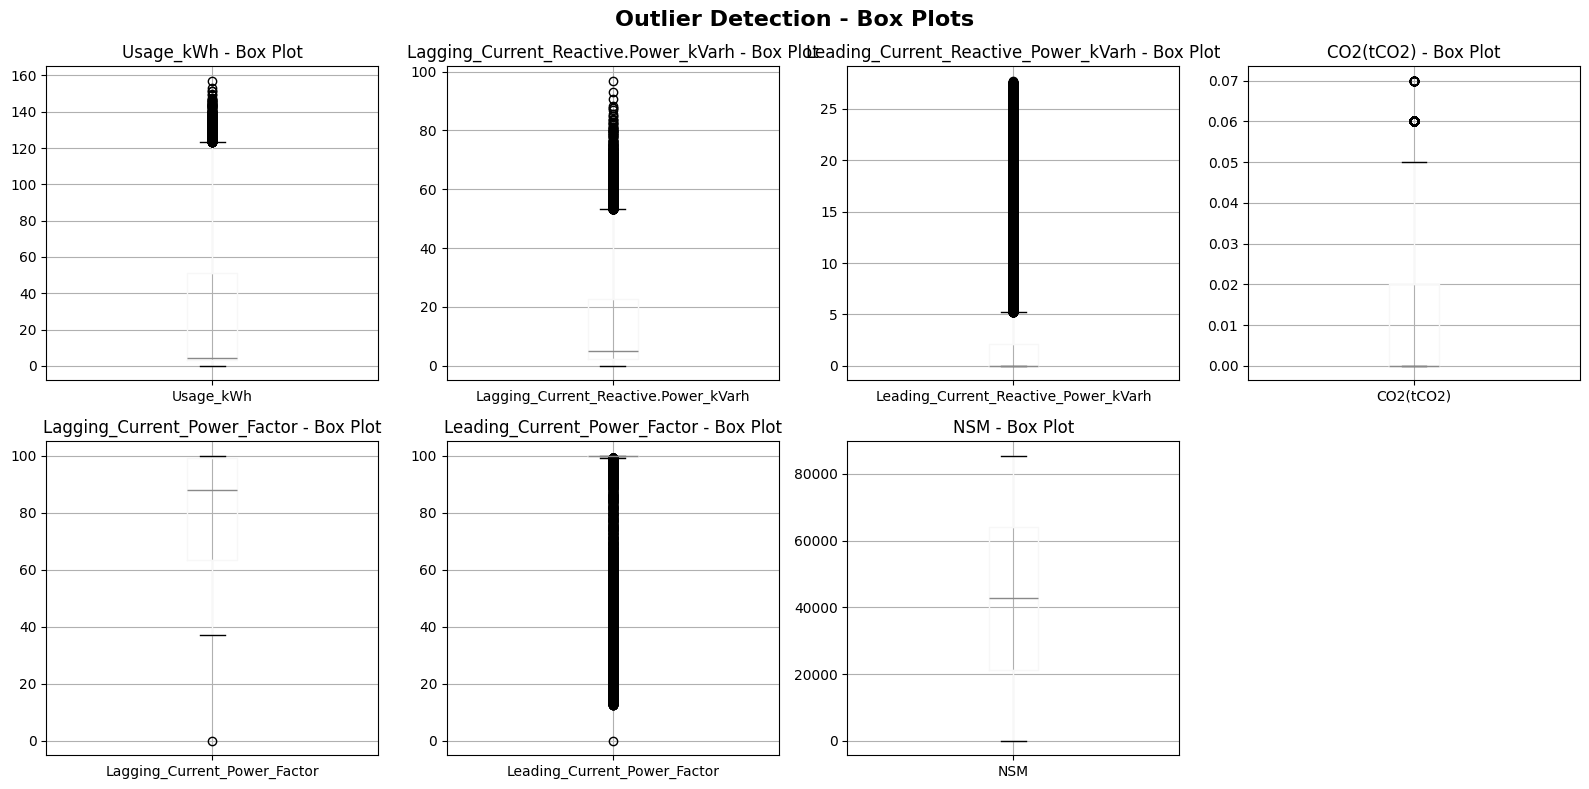

In [8]:
# Visualize outliers using box plots
if len(numerical_cols) > 0:
    # Create box plots for numerical features
    n_cols = min(4, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            df.boxplot(column=col, ax=axes[i])
            axes[i].set_title(f'{col} - Box Plot')
            axes[i].set_xlabel('')
    
    # Hide extra subplots
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Outlier Detection - Box Plots', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 6. Data Range Validation

In [9]:
# Validate data ranges for specific features
print("=== DATA RANGE VALIDATION ===")

# Define expected ranges for key features
expected_ranges = {
    'Usage_kWh': (0, None),  # Should be positive
    'Lagging_Current_Power_Factor': (0, 100),  # Typically 0-100
    'Leading_Current_Power_Factor': (0, 100),  # Typically 0-100
    'NSM': (0, None),  # Should be positive
    'CO2(tCO2)': (0, None)  # Should be non-negative
}

range_issues = []

for col, (min_val, max_val) in expected_ranges.items():
    if col in df.columns:
        col_min = df[col].min()
        col_max = df[col].max()
        
        issues = []
        if min_val is not None and col_min < min_val:
            issues.append(f"Min value {col_min} < expected {min_val}")
        if max_val is not None and col_max > max_val:
            issues.append(f"Max value {col_max} > expected {max_val}")
        
        if issues:
            print(f"⚠️ {col}: {', '.join(issues)}")
            range_issues.append(col)
        else:
            print(f"✓ {col}: Range [{col_min:.2f}, {col_max:.2f}] is valid")

if range_issues:
    print(f"\n⚠️ Found range issues in {len(range_issues)} columns")
else:
    print("\n✓ All data ranges are valid")

=== DATA RANGE VALIDATION ===
✓ Usage_kWh: Range [0.00, 157.18] is valid
✓ Lagging_Current_Power_Factor: Range [0.00, 100.00] is valid
✓ Leading_Current_Power_Factor: Range [0.00, 100.00] is valid
✓ NSM: Range [0.00, 85500.00] is valid
✓ CO2(tCO2): Range [0.00, 0.07] is valid

✓ All data ranges are valid


## 7. Categorical Data Validation

In [10]:
# Validate categorical features
print("=== CATEGORICAL DATA VALIDATION ===")

# Define expected values for categorical columns
expected_categories = {
    'Load_Type': ['Light_Load', 'Medium_Load', 'Maximum_Load'],
    'WeekStatus': ['Weekday', 'Weekend'],
    'Day_of_week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
}

categorical_issues = []

for col, expected_values in expected_categories.items():
    if col in df.columns:
        actual_values = set(df[col].unique())
        expected_set = set(expected_values)
        
        unexpected = actual_values - expected_set
        missing = expected_set - actual_values
        
        print(f"\n{col}:")
        print(f"  Expected: {expected_values}")
        print(f"  Actual: {list(actual_values)}")
        
        if unexpected:
            print(f"  ⚠️ Unexpected values: {list(unexpected)}")
            categorical_issues.append(f"{col}: unexpected values")
        
        if missing:
            print(f"  ⚠️ Missing expected values: {list(missing)}")
            categorical_issues.append(f"{col}: missing values")
        
        if not unexpected and not missing:
            print(f"  ✓ All values are valid")
        
        # Show value counts
        print(f"  Value counts: {dict(df[col].value_counts())}")

if categorical_issues:
    print(f"\n⚠️ Found {len(categorical_issues)} categorical data issues")
else:
    print("\n✓ All categorical data is valid")

=== CATEGORICAL DATA VALIDATION ===

Load_Type:
  Expected: ['Light_Load', 'Medium_Load', 'Maximum_Load']
  Actual: ['Medium_Load', 'Light_Load', 'Maximum_Load']
  ✓ All values are valid
  Value counts: {'Light_Load': np.int64(18072), 'Medium_Load': np.int64(9696), 'Maximum_Load': np.int64(7272)}

WeekStatus:
  Expected: ['Weekday', 'Weekend']
  Actual: ['Weekend', 'Weekday']
  ✓ All values are valid
  Value counts: {'Weekday': np.int64(25056), 'Weekend': np.int64(9984)}

Day_of_week:
  Expected: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  Actual: ['Sunday', 'Monday', 'Wednesday', 'Friday', 'Tuesday', 'Saturday', 'Thursday']
  ✓ All values are valid
  Value counts: {'Monday': np.int64(5088), 'Tuesday': np.int64(4992), 'Wednesday': np.int64(4992), 'Thursday': np.int64(4992), 'Friday': np.int64(4992), 'Saturday': np.int64(4992), 'Sunday': np.int64(4992)}

✓ All categorical data is valid


## 8. Statistical Validation

In [11]:
# Statistical tests and validation
print("=== STATISTICAL VALIDATION ===")

# Check for data distribution and normality
normality_results = []

for col in numerical_cols:
    if col in df.columns and len(df[col].dropna()) > 5000:  # Shapiro-Wilk is limited to 5000 samples
        # Use Kolmogorov-Smirnov test for large samples
        try:
            ks_stat, ks_p = stats.kstest(df[col].dropna(), 'norm',
                                       args=(df[col].mean(), df[col].std()))
            is_normal = ks_p > 0.05
            test_used = 'KS'
        except:
            ks_stat, ks_p = np.nan, np.nan
            is_normal = False
            test_used = 'Failed'
    elif col in df.columns:
        # Use Shapiro-Wilk test for smaller samples
        try:
            sw_stat, sw_p = stats.shapiro(df[col].dropna())
            is_normal = sw_p > 0.05
            ks_stat, ks_p = sw_stat, sw_p
            test_used = 'SW'
        except:
            ks_stat, ks_p = np.nan, np.nan
            is_normal = False
            test_used = 'Failed'
    else:
        continue
        
    normality_results.append({
        'Column': col,
        'Test': test_used,
        'Statistic': round(ks_stat, 4) if not np.isnan(ks_stat) else 'N/A',
        'P_Value': round(ks_p, 4) if not np.isnan(ks_p) else 'N/A',
        'Is_Normal': is_normal,
        'Skewness': round(df[col].skew(), 3),
        'Kurtosis': round(df[col].kurtosis(), 3)
    })

if normality_results:
    normality_df = pd.DataFrame(normality_results)
    print("\nNormality Test Results:")
    print(normality_df)
    
    non_normal_cols = normality_df[normality_df['Is_Normal'] == False]['Column'].tolist()
    if non_normal_cols:
        print(f"\n⚠️ Non-normal distributions detected in: {non_normal_cols}")
        print("Consider transformation for modeling if needed.")
    else:
        print("\n✓ All numerical features follow normal distribution")

=== STATISTICAL VALIDATION ===

Normality Test Results:
                                 Column Test  Statistic  P_Value  Is_Normal  \
0                             Usage_kWh   KS     0.3123      0.0      False   
1  Lagging_Current_Reactive.Power_kVarh   KS     0.2875      0.0      False   
2  Leading_Current_Reactive_Power_kVarh   KS     0.4005      0.0      False   
3                             CO2(tCO2)   KS     0.3613      0.0      False   
4          Lagging_Current_Power_Factor   KS     0.1523      0.0      False   
5          Leading_Current_Power_Factor   KS     0.4502      0.0      False   
6                                   NSM   KS     0.0624      0.0      False   

   Skewness  Kurtosis  
0     1.197     0.391  
1     1.438     1.214  
2     1.734     1.581  
3     1.149     0.215  
4    -0.606    -1.096  
5    -1.512     0.383  
6     0.000    -1.200  

⚠️ Non-normal distributions detected in: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reacti

## 9. Business Logic Validation

In [12]:
# Business logic and domain-specific validation
print("=== BUSINESS LOGIC VALIDATION ===")

business_issues = []

# Check if power factors are reasonable
if 'Lagging_Current_Power_Factor' in df.columns:
    invalid_lagging_pf = df[
        (df['Lagging_Current_Power_Factor'] < 0) | 
        (df['Lagging_Current_Power_Factor'] > 100)
    ]
    if len(invalid_lagging_pf) > 0:
        print(f"⚠️ Found {len(invalid_lagging_pf)} rows with invalid Lagging Power Factor")
        business_issues.append("Invalid Lagging Power Factor")
    else:
        print("✓ Lagging Power Factor values are valid")

if 'Leading_Current_Power_Factor' in df.columns:
    invalid_leading_pf = df[
        (df['Leading_Current_Power_Factor'] < 0) | 
        (df['Leading_Current_Power_Factor'] > 100)
    ]
    if len(invalid_leading_pf) > 0:
        print(f"⚠️ Found {len(invalid_leading_pf)} rows with invalid Leading Power Factor")
        business_issues.append("Invalid Leading Power Factor")
    else:
        print("✓ Leading Power Factor values are valid")

# Check for logical consistency between weekend status and day of week
if 'WeekStatus' in df.columns and 'Day_of_week' in df.columns:
    weekend_days = ['Saturday', 'Sunday']
    weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    inconsistent_weekend = df[
        (df['WeekStatus'] == 'Weekend') & 
        (~df['Day_of_week'].isin(weekend_days))
    ]
    
    inconsistent_weekday = df[
        (df['WeekStatus'] == 'Weekday') & 
        (~df['Day_of_week'].isin(weekday_days))
    ]
    
    total_inconsistent = len(inconsistent_weekend) + len(inconsistent_weekday)
    
    if total_inconsistent > 0:
        print(f"⚠️ Found {total_inconsistent} rows with inconsistent WeekStatus and Day_of_week")
        business_issues.append("Inconsistent WeekStatus/Day_of_week")
        if len(inconsistent_weekend) > 0:
            print(f"  - Weekend status but weekday: {len(inconsistent_weekend)} rows")
        if len(inconsistent_weekday) > 0:
            print(f"  - Weekday status but weekend: {len(inconsistent_weekday)} rows")
    else:
        print("✓ WeekStatus and Day_of_week are consistent")

# Check for energy consumption patterns
if 'Usage_kWh' in df.columns:
    zero_usage = df[df['Usage_kWh'] == 0]
    if len(zero_usage) > 0:
        print(f"⚠️ Found {len(zero_usage)} rows with zero energy usage")
        print("This might be valid (maintenance periods) or data quality issue")
    else:
        print("✓ No zero energy usage found")

if business_issues:
    print(f"\n⚠️ Found {len(business_issues)} business logic issues")
else:
    print("\n✓ All business logic validations passed")

=== BUSINESS LOGIC VALIDATION ===
✓ Lagging Power Factor values are valid
✓ Leading Power Factor values are valid
✓ WeekStatus and Day_of_week are consistent
⚠️ Found 1 rows with zero energy usage
This might be valid (maintenance periods) or data quality issue

✓ All business logic validations passed


## 10. Data Quality Score

In [13]:
# Calculate overall data quality score
print("=== DATA QUALITY SCORE ===")

# Initialize score components
score_components = {
    'completeness': 0,
    'uniqueness': 0,
    'validity': 0,
    'consistency': 0,
    'accuracy': 0
}

# Completeness: No missing values
missing_ratio = df.isnull().sum().sum() / (df.shape[0] * df.shape[1])
score_components['completeness'] = max(0, (1 - missing_ratio) * 100)

# Uniqueness: No duplicates
duplicate_ratio = df.duplicated().sum() / len(df)
score_components['uniqueness'] = max(0, (1 - duplicate_ratio) * 100)

# Validity: Data types and ranges
validity_issues = len(type_issues) + len(range_issues) + len(categorical_issues)
total_checks = len(expected_types) + len(expected_ranges) + len(expected_categories)
score_components['validity'] = max(0, ((total_checks - validity_issues) / total_checks) * 100) if total_checks > 0 else 100

# Consistency: Business logic
consistency_score = max(0, 100 - len(business_issues) * 20)  # Deduct 20 points per issue
score_components['consistency'] = consistency_score

# Accuracy: Outlier ratio (simplified)
if len(outlier_df) > 0:
    avg_outlier_percentage = outlier_df['IQR_Percentage'].mean()
    accuracy_score = max(0, 100 - avg_outlier_percentage)  # Deduct based on outlier percentage
else:
    accuracy_score = 100
score_components['accuracy'] = accuracy_score

# Calculate overall score (weighted average)
weights = {
    'completeness': 0.25,
    'uniqueness': 0.15,
    'validity': 0.25,
    'consistency': 0.20,
    'accuracy': 0.15
}

overall_score = sum(score_components[key] * weights[key] for key in weights.keys())

print("\nData Quality Score Breakdown:")
for component, score in score_components.items():
    status = "✓" if score >= 80 else "⚠️" if score >= 60 else "❌"
    print(f"{status} {component.capitalize():15}: {score:6.2f}/100")

print(f"\nOverall Data Quality Score: {overall_score:.2f}/100")

if overall_score >= 90:
    print("🌟 Excellent data quality!")
elif overall_score >= 80:
    print("✅ Good data quality")
elif overall_score >= 70:
    print("⚠️ Acceptable data quality with some issues")
else:
    print("❌ Poor data quality - significant issues need addressing")

=== DATA QUALITY SCORE ===

Data Quality Score Breakdown:
✓ Completeness   : 100.00/100
✓ Uniqueness     : 100.00/100
✓ Validity       : 100.00/100
✓ Consistency    : 100.00/100
✓ Accuracy       :  92.70/100

Overall Data Quality Score: 98.90/100
🌟 Excellent data quality!


## 11. Save Validated Data

In [14]:
# Save the validated data
output_filename = 'validated_data.csv'

try:
    # Create a copy of the dataframe for any final cleaning
    validated_df = df.copy()
    
    # Optional: Apply any critical fixes here
    # For example, remove duplicates if found:
    if complete_duplicates > 0:
        print(f"Removing {complete_duplicates} duplicate rows...")
        validated_df = validated_df.drop_duplicates()
    
    # Save the validated data
    validated_df.to_csv(output_filename, index=False)
    
    print(f"✓ Validated data successfully saved to {output_filename}")
    print(f"Original dataset shape: {df.shape}")
    print(f"Validated dataset shape: {validated_df.shape}")
    print(f"Rows removed: {df.shape[0] - validated_df.shape[0]}")
    
    # Verify the saved file
    test_df = pd.read_csv(output_filename)
    if test_df.shape == validated_df.shape:
        print("✓ File integrity verified")
    else:
        print("⚠️ File integrity check failed")
        
except Exception as e:
    print(f"❌ Error saving data: {e}")

✓ Validated data successfully saved to validated_data.csv
Original dataset shape: (35040, 16)
Validated dataset shape: (35040, 16)
Rows removed: 0
✓ File integrity verified


## 12. Validation Summary Report

In [15]:
# Generate comprehensive validation summary
print("" + "="*60 + "")
print("             DATA VALIDATION SUMMARY")
print("" + "="*60 + "")

print(f"📊 Dataset Information:")
print(f"   • Input file: {input_filename}")
print(f"   • Output file: {output_filename}")
print(f"   • Original shape: {df.shape}")
print(f"   • Final shape: {validated_df.shape if 'validated_df' in locals() else df.shape}")

print(f"\n🔍 Validation Results:")
print(f"   • Data Quality Score: {overall_score:.1f}/100")
print(f"   • Missing values: {missing_summary.sum():,}")
print(f"   • Duplicate rows: {complete_duplicates:,}")
print(f"   • Data type issues: {len(type_issues)}")
print(f"   • Range validation issues: {len(range_issues)}")
print(f"   • Categorical issues: {len(categorical_issues)}")
print(f"   • Business logic issues: {len(business_issues)}")

print(f"\n📈 Statistical Summary:")
if len(outlier_df) > 0:
    print(f"   • Average outliers (IQR): {outlier_df['IQR_Percentage'].mean():.1f}%")
    print(f"   • Max outliers in column: {outlier_df.loc[outlier_df['IQR_Percentage'].idxmax(), 'Column']} ({outlier_df['IQR_Percentage'].max():.1f}%)")
else:
    print(f"   • No numerical columns for outlier analysis")

print(f"\n✅ Quality Assessment:")
for component, score in score_components.items():
    status_icon = "🟢" if score >= 80 else "🟡" if score >= 60 else "🔴"
    print(f"   {status_icon} {component.capitalize()}: {score:.1f}/100")

print(f"\n🎯 Recommendations:")
recommendations = []
if score_components['completeness'] < 90:
    recommendations.append("Address missing values before modeling")
if score_components['uniqueness'] < 90:
    recommendations.append("Remove duplicate records")
if score_components['validity'] < 80:
    recommendations.append("Fix data type and range issues")
if score_components['consistency'] < 80:
    recommendations.append("Resolve business logic inconsistencies")
if score_components['accuracy'] < 70:
    recommendations.append("Consider outlier treatment strategies")

if recommendations:
    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")
else:
    print("   🌟 Data quality is excellent - ready for transformation!")

print("" + "="*60 + "")
print("Data Validation Phase Completed Successfully!")
print(f"Timestamp: {datetime.now()}")

             DATA VALIDATION SUMMARY
📊 Dataset Information:
   • Input file: ingested_data.csv
   • Output file: validated_data.csv
   • Original shape: (35040, 16)
   • Final shape: (35040, 16)

🔍 Validation Results:
   • Data Quality Score: 98.9/100
   • Missing values: 0
   • Duplicate rows: 0
   • Data type issues: 0
   • Range validation issues: 0
   • Categorical issues: 0
   • Business logic issues: 0

📈 Statistical Summary:
   • Average outliers (IQR): 7.3%
   • Max outliers in column: Leading_Current_Power_Factor (23.8%)

✅ Quality Assessment:
   🟢 Completeness: 100.0/100
   🟢 Uniqueness: 100.0/100
   🟢 Validity: 100.0/100
   🟢 Consistency: 100.0/100
   🟢 Accuracy: 92.7/100

🎯 Recommendations:
   🌟 Data quality is excellent - ready for transformation!
Data Validation Phase Completed Successfully!
Timestamp: 2025-10-13 09:57:33.783912
